The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
No GPU available, using the CPU instead.


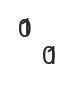

In [52]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from torch import optim
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import onehot_decode, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.data_processing import get_dataset
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from src.metrics import get_metrics, plot_roc_auc_fold, get_mean_roc_curve, get_mean_pr_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance, get_roc
from src.sklearn_train_eval import kcv_tune_sklearn, evaluate_trained_models_sklearn, nested_kcv_train_sklearn
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump

from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon
from sklearn.ensemble import RandomForestClassifier

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'

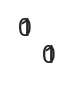

In [2]:
mpl.rcParams['figure.dpi'] = 180
sns.set_palette(HSV)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

# init

## reloading datasets

In [37]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')

In [5]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## Baselines

In [4]:
cedar_related[['Peptide', 'agg_label']].to_csv('../../nnalign_cedar/baseline_data/221115_cedar_related.pep', sep = '\t', index=False, header=False)
prime_related[['Peptide', 'agg_label']].to_csv('../../nnalign_cedar/baseline_data/221115_prime_related.pep', sep = '\t', index=False, header=False)
ibel[['Peptide', 'agg_label']].to_csv('../../nnalign_cedar/baseline_data/221115_ibel_related.pep', sep = '\t', index=False, header=False)
merged[['Peptide', 'agg_label']].to_csv('../../nnalign_cedar/baseline_data/221115_cedar_prime_merged.pep', sep = '\t', index=False, header=False)

3480


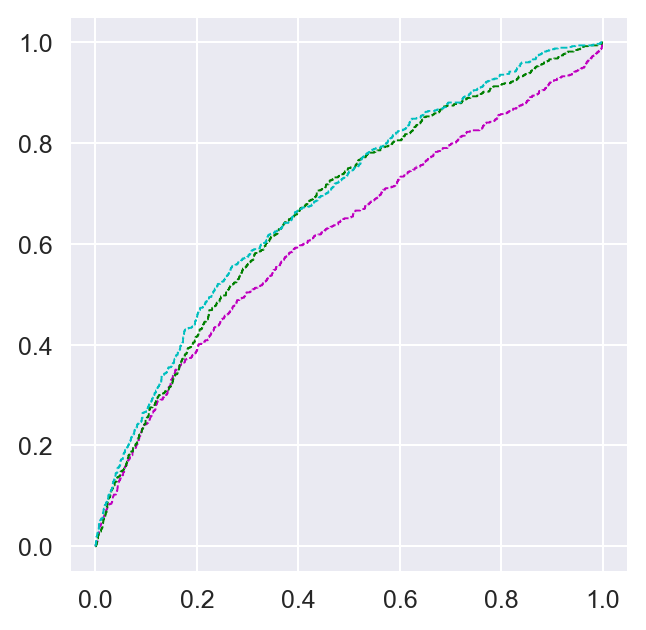

In [7]:
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)

In [8]:
from src.baselines import plot_related_baseline_roc

Text(0.5, 1.0, 'Baseline ROCs on IBEL')

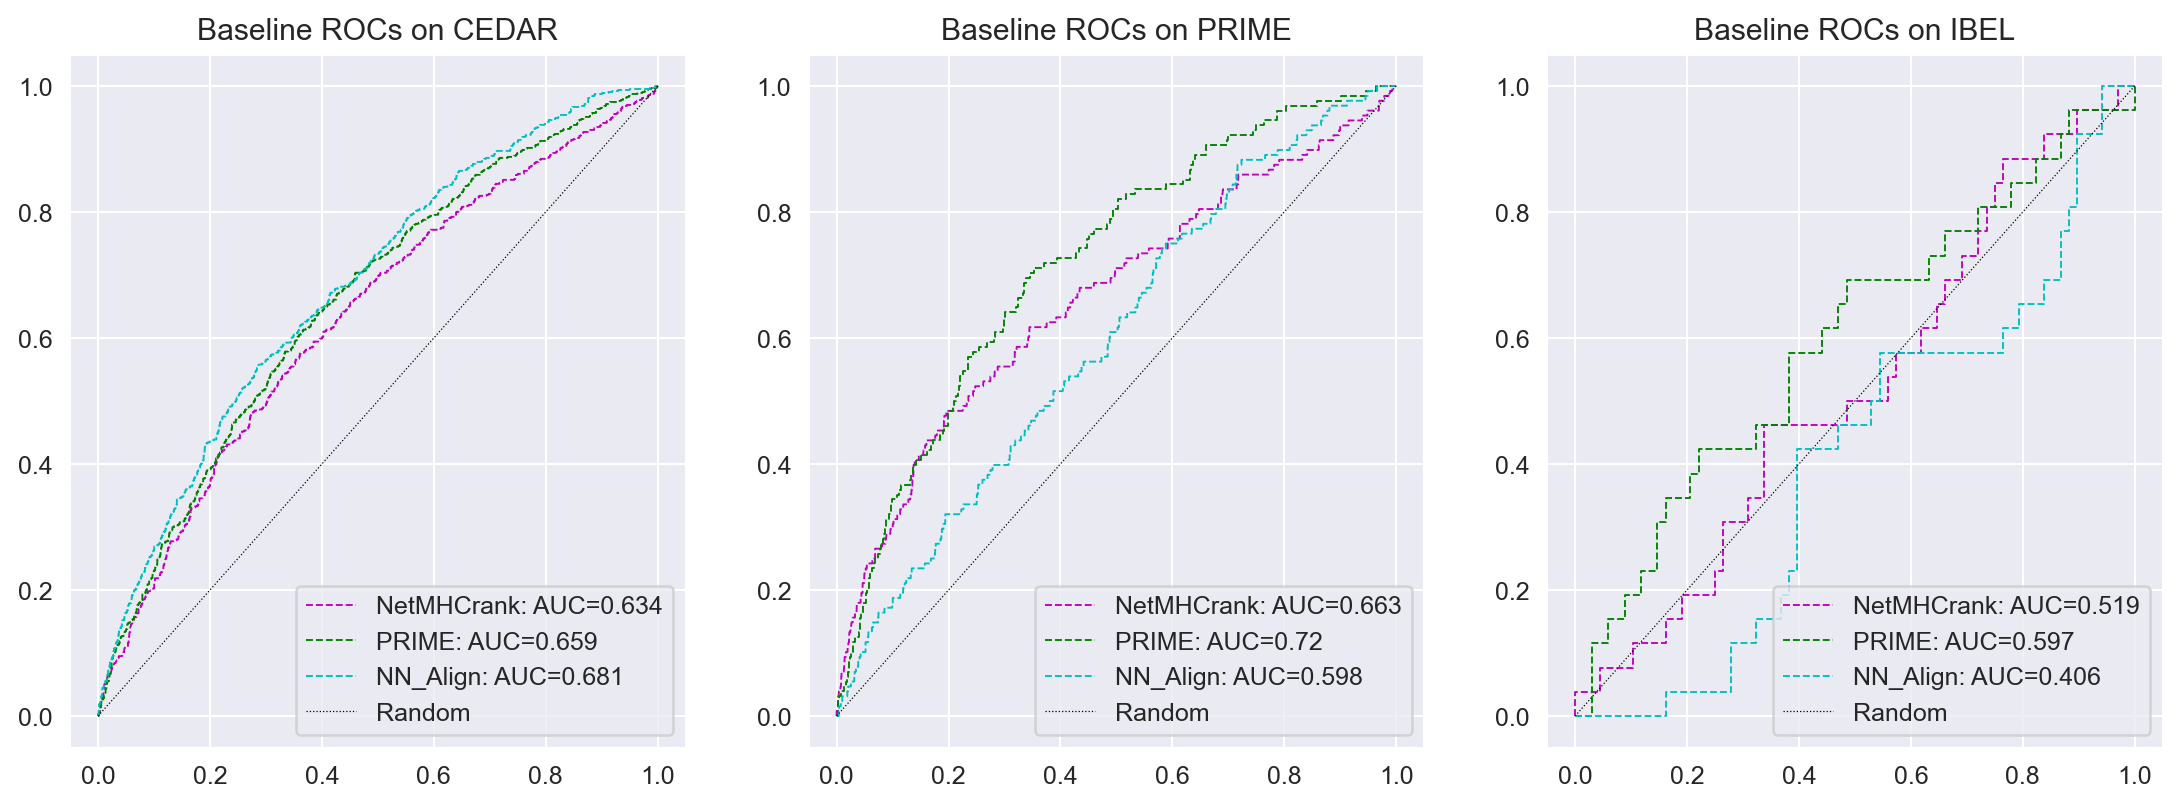

In [9]:
f,a = plt.subplots(1,3, figsize=(15,5))
plot_related_baseline_roc(axis=a[1], dataset=prime_related_baseline)
# a[1].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[1].legend(loc='lower right')
a[1].set_title('Baseline ROCs on PRIME')
plot_related_baseline_roc(axis=a[0], dataset=cedar_related_baseline)
# a[0].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[0].legend(loc='lower right')
a[0].set_title('Baseline ROCs on CEDAR')

plot_related_baseline_roc(axis=a[2], dataset=ibel)
# a[2].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[2].legend(loc='lower right')
a[2].set_title('Baseline ROCs on IBEL')

# Redo NNalign with custom partition

## Make folds for PRIME and IBEL

In [25]:
# Since Ibel's dataset is very small, make random partition (5fold)
from sklearn.model_selection import StratifiedKFold 
kf = StratifiedKFold(5, shuffle=True, random_state=13)
ibel['fold'] = 0
for i, (_, test) in enumerate(kf.split(ibel['Peptide'], ibel['Target'])):
    ibel.iloc[test, ibel.columns.get_loc('fold')] = i

In [31]:
ibel.to_csv('../data/mutant/221117_ibel_merged_fold.csv', index=False)

In [28]:
# Make folds for PRIME using hobohm-1 (sim = 0.9)
prime_related['Peptide'].to_csv('../../kern_dist/data/221117_prime_related.pep', index=False, header=False)

In [30]:
from src.partition_tools import pipeline_stratified_kfold
prime_related = pipeline_stratified_kfold('../../kern_dist/out/221117_prime_related.pep_0.9.out', prime_related.reset_index(drop=True), 
                          k=5, shuffle=True, seed = 13, pep_col='Peptide', elrank_col='EL_rank_mut')
prime_related.to_csv('../data/mutant/221117_prime_related_newcore_fold.csv', index=False)

read hobohm 2389 739
strat kfold unique 2389 739
manually reassign identical 2389 739
manually reassign related 2389 739
concat 3128
merge 3128
drop duplicated 3109


## Saving with fold

In [36]:
ibel[['Peptide', 'agg_label', 'fold']].to_csv('../../nnalign_cedar/fold/data_fold/221117_ibel_fold.pep' ,index=False, header=False, sep='\t')
prime_related[['Peptide', 'agg_label', 'fold']].to_csv('../../nnalign_cedar/fold/data_fold/221117_prime_related_fold.pep',
                                                       index=False, header=False, sep='\t')
cedar_related[['Peptide', 'agg_label', 'fold']].to_csv('../../nnalign_cedar/fold/data_fold/221117_cedar_fold.pep',
                                              index=False, header=False, sep='\t')


# Old scratchpad

## Data Processing

In [10]:
# TODO : NEED TO IMPLEMENT "ADAPTIVE" WEIGHTING FOR ANCHOR/NON ANCHOR MUTATION
# At the moment, just include Anchor/NonAnchor as features (0, 1)
from src.data_processing import get_freq_tensors, get_mutation_tensors, BL62_VALUES, BL62FREQ_VALUES, encode_batch_weighted
train = dataset.query('fold!=0 and fold !=1')
valid = dataset.query('fold==1')
test = dataset.query('fold==0')

In [11]:
xxx = encode_batch_weighted(test, ics_kl, None, 12, 'blosum', BL62_VALUES)
xxx.shape

torch.Size([296, 12, 20])

In [12]:
xmut = encode_batch_weighted(test, ics_kl, None, 12, 'blosum', BL62_VALUES).view(-1,12*20)
xwt = encode_batch_weighted(test, ics_kl, None, 12, 'blosum', BL62_VALUES, seq_col='wild_type').view(-1,12*20)
xfeats = torch.from_numpy(test[feature_columns].values)
xmut.shape, xwt.shape, xfeats.shape

(torch.Size([296, 240]), torch.Size([296, 240]), torch.Size([296, 14]))

In [26]:
from src.data_processing import get_tensor_dataset
x,y = get_tensor_dataset(test, ics_kl, 'cuda', 'mutation', 12, 'onehot', None, feat_cols = feature_columns, invert=True)
print(x.shape, y.shape)
x,y = get_tensor_dataset(test, ics_kl, 'cuda', 'aafreq', 12, 'onehot', None, feat_cols = feature_columns, invert=True)
print(x.shape, y.shape)

torch.Size([296, 494]) torch.Size([296, 1])
torch.Size([296, 20]) torch.Size([296, 1])


## Model & Runs

## Model Def

In [288]:
dataset.columns

Index(['Peptide', 'HLA', 'trueHLA_EL_rank', 'agg_label', 'fold', 'BA_rank',
       'BA_score', 'BinderMutation', 'HLA_full', 'PMIDs',
       'Related Object_Ending Position', 'Related Object_Starting Position',
       'anchor_mutation', 'binder', 'core', 'core_mutation_position',
       'delta_VHSE1', 'delta_VHSE3', 'delta_VHSE7', 'delta_VHSE8',
       'delta_aliphatic_index', 'delta_boman', 'delta_hydrophobicity',
       'delta_isoelectric_point', 'delta_rank', 'icore', 'label', 'len',
       'len_wt', 'mhc_anchor', 'mutation', 'mutation_position',
       'mutation_score', 'mutation_type', 'percentage_pos', 'pred_EL_rank',
       'pred_EL_score', 'pred_HLA', 'rank_ratio', 'responses', 'total_count',
       'trainset', 'wild_type', 'wt_EL_rank', 'wt_core', 'wt_true'],
      dtype='object')

In [20]:
from src.models import Standardizer, ConvBlock, DICNN, NetWrapper
x_props = x[:, -14:]
nw = NetWrapper(12, 10, 30, 14)
print(nw.standardizer.mu)
nw.standardizer.fit(x_props)
print(nw.standardizer.mu)
nw.reset_parameters(seed=2)
print(nw.standardizer.mu)

0
tensor([ 0.4392,  0.0441,  0.0484, -0.0322, -0.0659,  4.8216, -0.1694,  0.1214,
         0.0865,  2.7635,  1.0087, 15.6234,  1.6070,  4.3705], device='cuda:0')
0


In [27]:
hasattr(nw, 'standardizer')

True

In [22]:
nw.standardizer.fit(x_props)
nw.to(device)
nw(x).shape

torch.Size([14]) torch.Size([296, 14])


torch.Size([296, 1])

In [24]:
issubclass(nw.__class__, nn.Module)

True

In [25]:
rf = LogisticRegression()
issubclass(rf.__class__, sklearn.base.BaseEstimator)

True

## Pipeline
TODO:
Adapt the current pipeline & change the train / eval fct to return prediction dfs and use the new encoding with mutation_tensors

- Change data processing / Loading in train/eval fct

- Deal with extra features std

- Change model handling and/or concatenate

# NN expl:

either fully linear NN to use standard input

or CNN for seq + linear for additional features

In [54]:
from joblib import Parallel, delayed
from functools import partial
import multiprocessing
import itertools
from src.data_processing import get_aa_properties, get_dataset
from src.bootstrap import bootstrap
from sklearn.ensemble import RandomForestClassifier
from copy import deepcopy
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler




Do standard NN first because it will be easier to just adapt (inshallah) a few fcts to handle the features as they currently are

In [50]:
from src.models import FFNetWrapper
ffn = FFNetWrapper(n_in=21, n_hidden=10, n_layers=1, act=nn.ReLU())

In [51]:
x_train = torch.rand(size = [10000, 21])
y_train = torch.randint(low=0, high=1, size=[10000,1])

x_test = torch.rand(size = [100, 21])
y_test = torch.randint(low=0, high=1, size=[100,1])
print(ffn.standardizer.sigma)
ffn.fit_standardizer(x_train)
print(ffn.standardizer.sigma)
ffn.reset_parameters()
print(ffn.standardizer.sigma)

1
tensor([0.2844, 0.2916, 0.2902, 0.2887, 0.2885, 0.2898, 0.2903, 0.2895, 0.2904,
        0.2856, 0.2879, 0.2879, 0.2894, 0.2888, 0.2868, 0.2894, 0.2898, 0.2876,
        0.2898, 0.2882, 0.2889])
0
